Epoch 1/400


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6063 - loss: 0.7190 - val_accuracy: 0.0000e+00 - val_loss: 0.9706
Epoch 2/400
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.5776 - loss: 0.6921 - val_accuracy: 0.0000e+00 - val_loss: 0.9361
Epoch 3/400
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.5925 - loss: 0.6769 - val_accuracy: 0.0000e+00 - val_loss: 0.9558
Epoch 4/400
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.6084 - loss: 0.6707 - val_accuracy: 0.0000e+00 - val_loss: 0.9487
Epoch 5/400
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.6062 - loss: 0.6699 - val_accuracy: 0.0000e+00 - val_loss: 0.9469
Epoch 6/400
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6148 - loss: 0.6632 - val_accuracy: 0.0000e+00 - val_loss: 0.9489
Epoch 7/400
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.6099 - loss: 0.6588 - val_accuracy: 0.0000e+00 - val_loss: 0.9479
Epoch 8/400
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.

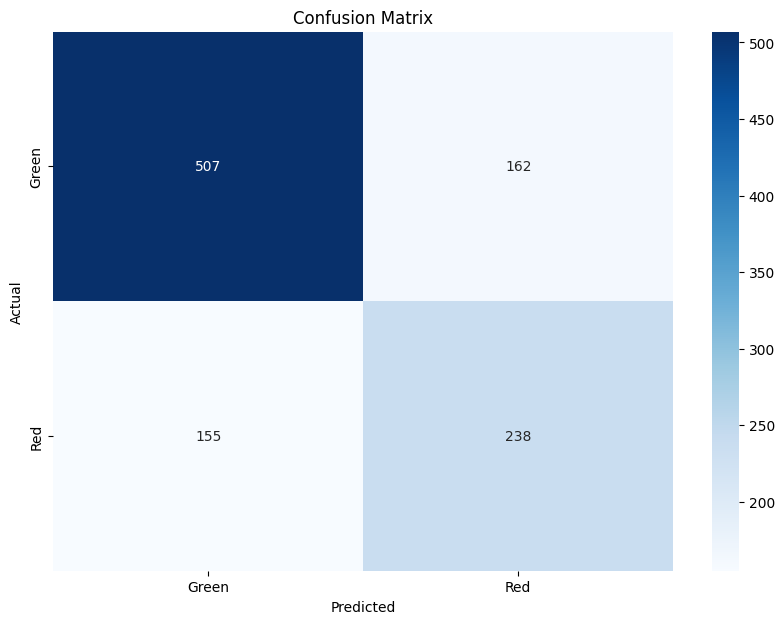

Classification Report:
              precision    recall  f1-score   support

       Green       0.77      0.76      0.76       669
         Red       0.59      0.61      0.60       393

    accuracy                           0.70      1062
   macro avg       0.68      0.68      0.68      1062
weighted avg       0.70      0.70      0.70      1062



['label_encoder_v2.pkl']

In [10]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
train_data = pd.read_csv('Training_dt.csv')
train_data = train_data.drop('Mask No', axis=1)
test_data = pd.read_csv('Testing_dt.csv')
test_data = test_data.drop('Mask No', axis=1)

# Define columns
numerical_cols = ['LEASE_TENOR_INCLUDING_HP', 'CUSTOMER AGE', 'Exp','YOM' ]
categorical_cols = ['PRODUCT_NAME', 'Sub_purpose_code_based_on_risk', 'CRIB_SCORE', 'TOTAL INCOME',
                    'Percentage_of_Total_Installments_to_Total_Current_Balance_slabs',
                    'Percentage_of_Total_Current_Balance_to_Total_Amount_Granted_Limit_slabs',
                    'Percentage_of_Total_Arrears_Amount_to_Total_Amount_Granted_Limit_slabs']
target_col = 'Cluster'

# Preprocessing pipelines for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Preprocess the data
X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]

X_test = test_data.drop(columns=[target_col])
y_test = test_data[target_col]

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=64)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train_encoded)

# ANN model with additional hidden layers and tuned hyperparameters
model = Sequential()
model.add(Dense(39, input_dim=X_train_resampled.shape[1], activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(26, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))
model.add(Dropout(0.2))
#model.add(Dense(3, activation='softmax'))
#model.add(Dropout(0.2))
#model.add(Dense(25, activation='relu'))
#model.add(Dense(len(np.unique(y_train_resampled)), activation='softmax'))
model.add(Dense(2, activation='sigmoid'))

# Compile the model with a lower learning rate and additional epochs
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model with more epochs
model.fit(X_train_resampled, y_train_resampled, validation_split=0.2, epochs=400, batch_size=64, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_processed, y_test_encoded)
print(f'Test Accuracy: {accuracy}')

# Make predictions
y_pred = model.predict(X_test_processed)
y_pred_labels = np.argmax(y_pred, axis=1)

# Decode predictions back to original labels
y_pred_labels_decoded = label_encoder.inverse_transform(y_pred_labels)

# Generate confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_labels)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test_encoded, y_pred_labels, target_names=label_encoder.classes_)
print('Classification Report:')
print(report)

# Save predictions to a new file
test_data['Predicted_Cluster'] = y_pred_labels_decoded
test_data.to_csv('Testing_dt_with_Predictions.csv', index=False)


# Save the model and other necessary files
model.save('best_ann_model_v2.h5')
#joblib.dump(ml, 'best_ml_model_v2.pkl')
joblib.dump(preprocessor, 'preprocessor_v2.pkl')
joblib.dump(label_encoder, 'label_encoder_v2.pkl')

In [6]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Load the test dataset
test_data_1242 = pd.read_csv('testing_red.csv')
#test_data_1242 = test_data_1242.drop('Mask No', axis=1)

# Define columns
numerical_cols = ['LEASE_TENOR_INCLUDING_HP', 'CUSTOMER AGE', 'Exp', 'YOM']
categorical_cols = ['PRODUCT_NAME', 'Sub_purpose_code_based_on_risk', 'CRIB_SCORE', 'TOTAL INCOME',
                    'Percentage_of_Total_Installments_to_Total_Current_Balance_slabs',
                    'Percentage_of_Total_Current_Balance_to_Total_Amount_Granted_Limit_slabs',
                    'Percentage_of_Total_Arrears_Amount_to_Total_Amount_Granted_Limit_slabs']
#target_col = 'Cluster'

# Load the pre-trained models and encoders
model = tf.keras.models.load_model('best_ann_model_v2.h5')
preprocessor = joblib.load('preprocessor_v2.pkl')
label_encoder = joblib.load('label_encoder_v2.pkl')

# Preprocess the data
X_test_1242 = test_data_1242#.drop(columns=[target_col])
#y_test_1242 = test_data_1242[target_col]

X_test_1242_processed = preprocessor.transform(X_test_1242)
#y_test_1242_encoded = label_encoder.transform(y_test_1242)

# Make predictions
y_pred_1242 = model.predict(X_test_1242_processed)
y_pred_1242_labels = np.argmax(y_pred_1242, axis=1)

# Decode predictions back to original labels
y_pred_1242_labels_decoded = label_encoder.inverse_transform(y_pred_1242_labels)

# Generate confusion matrix
# cm_1242 = confusion_matrix(y_test_1242_encoded, y_pred_1242_labels)
# print('Confusion Matrix:')
# print(cm_1242)

# # Plot confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm_1242, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix for test1242.csv')
# plt.show()

# Generate classification report
# report_1242 = classification_report(y_test_1242_encoded, y_pred_1242_labels, target_names=label_encoder.classes_)
# print('Classification Report:')
# print(report_1242)

# Save predictions to a new file
test_data_1242['Predicted_Cluster'] = y_pred_1242_labels_decoded
test_data_1242.to_excel('test_red_with_Predictions.xlsx', index=False)


504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
